In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)


In [4]:
def load_images_from_directory(directory, target_size=(256, 256)):
    images = []
    for filename in os.listdir(directory):
        img = load_img(os.path.join(directory, filename), target_size=target_size)
        img = img_to_array(img) / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Directories for uneven and even images
uneven_images_dir = "D:\\final\\Dataset\\uneven"
even_images_dir = "D:\\final\\Dataset\\even"

# Load images
X_images = load_images_from_directory(uneven_images_dir)
Y_images = load_images_from_directory(even_images_dir)

# Check the shape of the loaded data
print(f'Uneven images shape: {X_images.shape}')
print(f'Even images shape: {Y_images.shape}')

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_images, test_size=0.2, random_state=42)


Uneven images shape: (299, 256, 256, 3)
Even images shape: (299, 256, 256, 3)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def attention_gate(x, g, inter_channels):
    """
    Attention Gate that applies spatial attention mechanism to the input feature map.
    """
    # Apply 1x1 convolutions to both x (skip connection) and g (current layer)
    theta_x = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), padding='same')(g)
    
    # Add both tensors together
    add_xg = layers.Add()([theta_x, phi_g])
    add_xg = layers.ReLU()(add_xg)
    
    # Convolution to generate attention map
    psi = layers.Conv2D(1, (1, 1), padding='same')(add_xg)
    psi = layers.Activation('sigmoid')(psi)
    
    # Multiply the input feature map with the attention map
    attn_map = layers.Multiply()([x, psi])
    return attn_map

def build_unet_with_attention(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (downsampling path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)    
    
    # Bridge
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = attention_gate(c4, u6, 256)  # Apply attention mechanism
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = attention_gate(c3, u7, 128)  # Apply attention mechanism
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = attention_gate(c2, u8, 64)  # Apply attention mechanism
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = attention_gate(c1, u9, 32)  # Apply attention mechanism
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
    
    # Create model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Build the U-Net model with Attention Mechanism
input_shape = (256, 256, 3)  # Image size and channels
unet_model = build_unet_with_attention(input_shape)

# Compile the model
unet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')

# Model summary
unet_model.summary()

# Training (Assuming you have X_train and Y_train already loaded)
history = unet_model.fit(
    X_train, Y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2
)

# Save the model after training
unet_model.save('illumination_unet_attention100.h5')




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                         

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 22s 10s/step


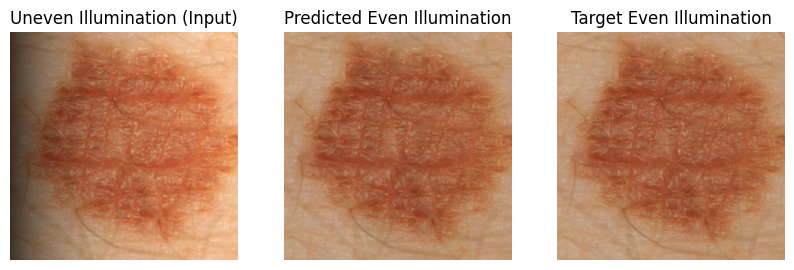

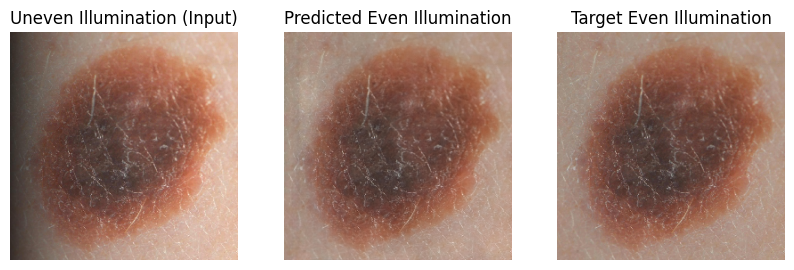

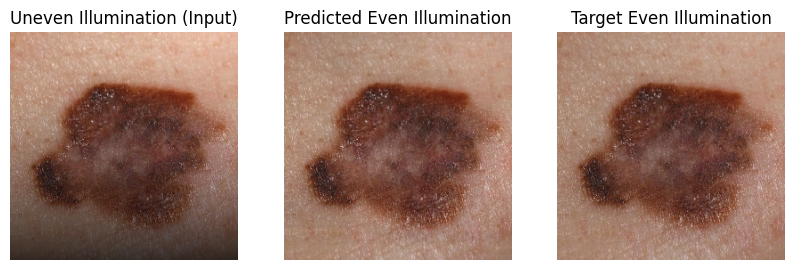

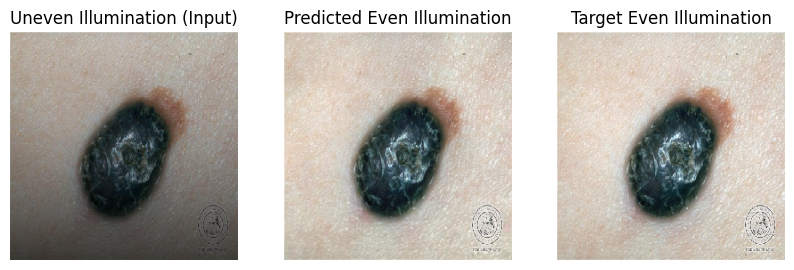

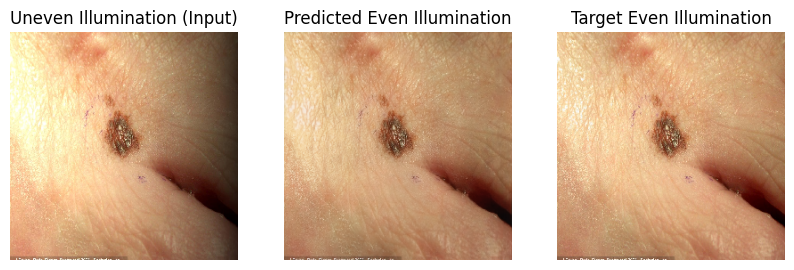

In [6]:
from tensorflow.keras.models import load_model

# unet_model = load_model('illumination_unet_attention100.h5')



predictions =unet_model.predict(X_test)

def display_results(input_image, predicted_image, target_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Uneven Illumination (Input)")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Even Illumination")
    plt.imshow(predicted_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Target Even Illumination")
    plt.imshow(target_image)
    plt.axis('off')

    plt.show()

for i in range(5):
    input_img = X_test[i]
    predicted_img = predictions[i]
    target_img = Y_test[i]

    display_results(input_img, predicted_img, target_img)


In [7]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def evaluate_image_quality(original, generated):
    original = original * 255.0  
    generated = generated * 255.0

    psnr_value = psnr(original, generated, data_range=255)

    ssim_value = ssim(original, generated, channel_axis=-1, data_range=255, win_size=3) 
    return psnr_value, ssim_value

PSNR = 0
SSIM = 0
for i in range(len(Y_test)):
    
    predicted_img = predictions[i]
    target_img = Y_test[i]

    psnr_val, ssim_val = evaluate_image_quality(target_img, predicted_img)
    print(f"PSNR of image{i+1}: {psnr_val}, SSIM of image{i+1}: {ssim_val}")
    PSNR += psnr_val
    SSIM += ssim_val

print(f"Average PSNR Value: {PSNR/len(Y_test)}, Average SSIM Value: {SSIM/len(Y_test)}")



PSNR of image1: 39.769631545513114, SSIM of image1: 0.9815006852149963
PSNR of image2: 33.8798460448574, SSIM of image2: 0.9752330780029297
PSNR of image3: 34.30867675163239, SSIM of image3: 0.9764506220817566
PSNR of image4: 29.040808268369798, SSIM of image4: 0.9423925280570984
PSNR of image5: 24.433276442640313, SSIM of image5: 0.9493257403373718
PSNR of image6: 38.482707309821286, SSIM of image6: 0.9750299453735352
PSNR of image7: 27.90634186285788, SSIM of image7: 0.9434804916381836
PSNR of image8: 20.7690868416799, SSIM of image8: 0.9382410049438477
PSNR of image9: 20.65607186582539, SSIM of image9: 0.9151492118835449
PSNR of image10: 35.78435362512933, SSIM of image10: 0.9780389666557312
PSNR of image11: 23.23341080510158, SSIM of image11: 0.9321341514587402
PSNR of image12: 35.875580177767375, SSIM of image12: 0.975196361541748
PSNR of image13: 32.660314315100905, SSIM of image13: 0.9795137047767639
PSNR of image14: 28.625793165224152, SSIM of image14: 0.9452937245368958
PSNR o